In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ydata_profiling as pp

from wordcloud import WordCloud
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

data is presampled as follows as 5% of the original 2M reviews dateset

df = pd.read_csv('TWITTER_REVIEWS.csv').sample(frac=0.05, replace=False)
df.to_csv('twitter_sample.csv', index=False)

In [8]:
df = pd.read_csv('twitter_sample.csv')

#deleting old index spared in initial dataset
df = df.drop(columns='Unnamed: 0')

df.head(3)

,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,4c3dab6d-6d7e-4aee-92e8-ec2588571ce5,185248414864621136184,A Google user,"First off my account was deactivated,i lost ev...",1,0,NaN,2012-04-07 20:40:56
1,dcde5998-3e52-457a-b5b1-ccdea1b757c0,113742698510423742613,A Google user,Good,5,0,8.11.0-release.00,2020-03-28 04:19:49
2,d37acd68-b810-49f0-aa60-e55f5b06976e,165212703262687555548,A Google user,Good,4,0,NaN,2017-05-15 10:27:47


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104243 entries, 0 to 104242
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   review_id           104243 non-null  object
 1   pseudo_author_id    104243 non-null  object
 2   author_name         104243 non-null  object
 3   review_text         104026 non-null  object
 4   review_rating       104243 non-null  int64 
 5   review_likes        104243 non-null  int64 
 6   author_app_version  77677 non-null   object
 7   review_timestamp    104243 non-null  object
dtypes: int64(2), object(6)
memory usage: 6.4+ MB


In [13]:
print(df.author_app_version.value_counts())

print("Number of releases {}".format(len(df.author_app_version.value_counts())))

8.25.1-release.01    630
8.92.0-release.00    511
9.98.0-release.0     476
5.39.0               472
8.74.1-release.00    449
                    ... 
7.17.0-beta.679        1
7.41.0-beta.772        1
7.93.3-release.01      1
8.88.0-beta.04         1
9.68.0-release.1       1
Name: author_app_version, Length: 698, dtype: int64
Number of releases 698


In [38]:
df['global_version'] = df.author_app_version.str.split(".").str[0]

len(set(df['global_version']))

12

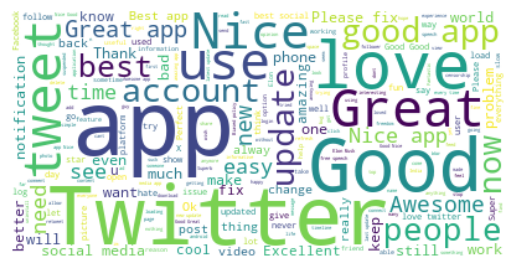

In [45]:
text_for_cloud = ' '.join(df['review_text'].dropna())

# cloud
cloud = WordCloud(background_color='white').generate(text_for_cloud)
 
# displaying
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()